# Assignment 13 Text Analytics

In this assignment, you will:
- Load and inspect a real-world business reviews dataset.
- Preprocess review text for NLP (tokenization, stopwords, lemmatization).
- Run sentiment analysis (rule-based and classifier-based) and compare to star ratings.
- Extract main topics from reviews using LDA and (optional) BERTopic.
- Interpret results in a business context (actionable insights).

## Why This Matters

Customer Reviews are critical for the survival of any business, but especially for restaurants.  Restaurants compete with not only all of the other restaurants in local area, but also with the option for customers to stay home and cook their own food.  Chefs and restaurant owners must monitor customer feedback to see if they should make changes to their pricing, menu options, restaurant amenities and seating/serving process.

You have been given 100 customer reviews.  Your job is to look for main topics that are mentioned, and whether those reviews have a postive, neutral or negative tone (sentiment).  

<a href="https://colab.research.google.com/github/Stan-Pugsley/is_4487_base/blob/main/Assignments/assignment_13_text_analytics.ipynb" target="_parent">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>



## Original Source: Dataset Description

The dataset you'll be using is a set of **restaurant reviews**, available from [Kaggle](https://www.kaggle.com/datasets/pruthvirajgshitole/e-commerce-purchases-and-reviews?utm_source=chatgpt.com&select=customer_purchase_data.csv).

Each row represents one customer review. The columns include:

- **Review** - text of the customer review
- **Liked** - indicates if the customer likes (1) or does not like (0) the restaurant

Please note that some reviews have commas and apostrophes, which can prevent the record from loading correctly.  You should verify that you have 1,000 reviews total.  

## 1. Load and Preview the Data

### Do the following:
1. Import your TSV file called `Restaurant_Reviews.tsv`.  Note that TSV is for Tab Separated Values.  This file does not use commas as a delimiter.
2. Use `pandas` to load and preview the dataset
3. Verify that all 1,000 rows were imported correctly
4. Calculate the overall percentage of reviews that "Liked" the restaurant
5. Create a visualization to show the percentage of likes versus non-likes


In [1]:
import pandas as pd
import csv

# Load the reviews
url = "https://raw.githubusercontent.com/Stan-Pugsley/is_4487_base/refs/heads/main/DataSets/Restaurant_Reviews.tsv"
df = pd.read_csv(url, sep='\t', quoting=csv.QUOTE_MINIMAL)

df.head()

,Review,Liked
0,Wow... Loved this place.,1
1,Crust is not good.,0
2,Not tasty and the texture was just nasty.,0
3,Stopped by during the late May bank holiday of...,1
4,The selection on the menu was great and so wer...,1


# Task
Verify the row count of the DataFrame `df`, calculate the percentage of 'Liked' (1) and 'Non-Liked' (0) reviews, and visualize the distribution of 'Liked' versus 'Non-Liked' reviews.

## Verify DataFrame row count

### Subtask:
Check if the DataFrame `df` contains 1,000 rows to ensure correct import.


**Reasoning**:
To verify the number of rows in the DataFrame, I will use the `.shape` attribute to get the dimensions of the DataFrame and print the row count.



In [2]:
print(f"Number of rows in the DataFrame: {df.shape[0]}")

Number of rows in the DataFrame: 1000


**Reasoning**:
Now that the row count is verified, I will calculate the percentage of 'Liked' and 'Non-Liked' reviews by using `value_counts()` on the 'Liked' column and normalizing the results, then print them.



In [3]:
liked_counts = df['Liked'].value_counts(normalize=True) * 100
print("Percentage of reviews:")
print(liked_counts)


Percentage of reviews:
Liked
1    50.0
0    50.0
Name: proportion, dtype: float64


**Reasoning**:
To visualize the distribution of 'Liked' versus 'Non-Liked' reviews, I will create a bar plot using `matplotlib.pyplot` and `seaborn` to make it visually appealing. This will clearly show the percentage of each category.



/tmp/ipython-input-2513929797.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=liked_counts.index, y=liked_counts.values, palette='viridis')


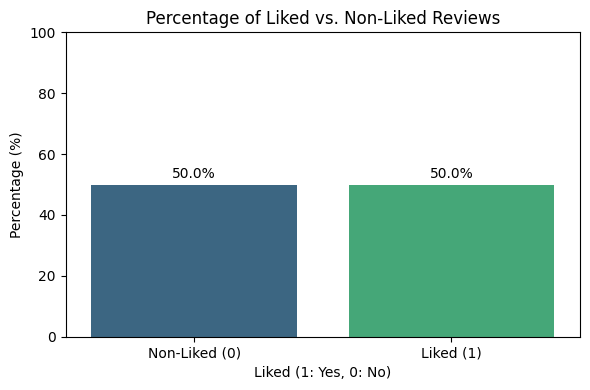

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(6, 4))
sns.barplot(x=liked_counts.index, y=liked_counts.values, palette='viridis')
plt.title('Percentage of Liked vs. Non-Liked Reviews')
plt.xlabel('Liked (1: Yes, 0: No)')
plt.ylabel('Percentage (%)')
plt.xticks([0, 1], ['Non-Liked (0)', 'Liked (1)'])
plt.ylim(0, 100)

for index, value in enumerate(liked_counts.values):
    plt.text(index, value + 2, f'{value:.1f}%', ha='center')

plt.tight_layout()
plt.show()

**Reasoning**:
To address the `FutureWarning` from seaborn and ensure compatibility with future versions, I will modify the `sns.barplot` call to explicitly set the `hue` parameter to `liked_counts.index` and `legend=False` as recommended in the warning.



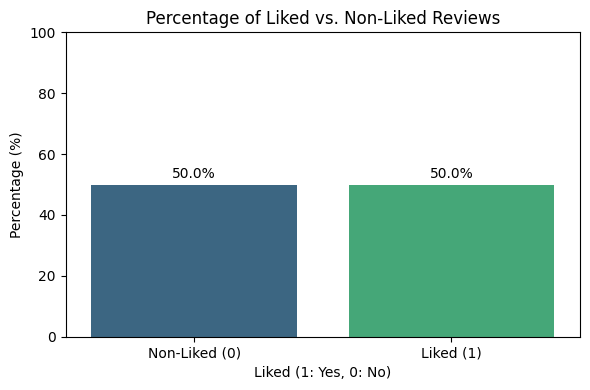

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(6, 4))
sns.barplot(x=liked_counts.index, y=liked_counts.values, hue=liked_counts.index, palette='viridis', legend=False)
plt.title('Percentage of Liked vs. Non-Liked Reviews')
plt.xlabel('Liked (1: Yes, 0: No)')
plt.ylabel('Percentage (%)')
plt.xticks([0, 1], ['Non-Liked (0)', 'Liked (1)'])
plt.ylim(0, 100)

for index, value in enumerate(liked_counts.values):
    plt.text(index, value + 2, f'{value:.1f}%', ha='center')

plt.tight_layout()
plt.show()

## 2. Drop Columns Not Useful for Modeling

**Business framing:**  
To do text analysis, we need to remove all of the junk in the reviews.  This would include anything like punctuation, website URLs, emojis, etc.

### Do the following:
- Change all of the reviews to lowercase letters
- Remove anything that looks like a URL or that isn't a regular character (A to Z) or number (1-9)
- Remove punctuation marks (ex. !.,-:;)

### In Your Response:
1. What risks might occur if you included the review "junk" in your model?


## Drop Columns Not Useful for Modeling

### Subtask:
Preprocess the 'Review' column by converting text to lowercase, removing URLs and non-alphanumeric characters, and removing punctuation marks.


**Reasoning**:
First, I will convert all review text to lowercase to ensure consistency. Then, I will remove URLs and punctuation using regular expressions, as these elements are not useful for text analysis.



In [6]:
import re

# Convert to lowercase
df['Review'] = df['Review'].str.lower()

# Remove URLs (a common pattern, can be refined for more complex cases)
df['Review'] = df['Review'].apply(lambda x: re.sub(r'http\S+|www\S+|https\S+', '', x, flags=re.MULTILINE))

# Remove non-alphanumeric characters and punctuation (keeping spaces)
df['Review'] = df['Review'].apply(lambda x: re.sub(r'[^a-zA-Z0-9\s]', '', x))

# Display the first few rows to verify changes
print(df.head())

                                              Review  Liked
0                               wow loved this place      1
1                                  crust is not good      0
2           not tasty and the texture was just nasty      0
3  stopped by during the late may bank holiday of...      1
4  the selection on the menu was great and so wer...      1


### ✍️ Your Response: 🔧
1. Including 'junk' (such as punctuation, URLs, non-alphanumeric characters, etc.) in a text analysis model can introduce several risks. It can lead to noise in the data, making it harder for the model to identify meaningful patterns and topics. This noise can also increase processing time and computational resources, as the model has to process irrelevant information. Furthermore, 'junk' might be misinterpreted by the model, leading to skewed sentiment scores or incorrect topic assignments. Ultimately, it can degrade the overall performance and accuracy of the model, making the insights derived less reliable for business decisions.

## 3. Sentiment Analysis

**Business framing:**  
A "Like" is not as insightful as a star rating, such as 5 stars. It only has two values. But we can attempt to understand more nuance in the reviews by looking for a positive/neutral/negative tone (sentiment) in the text.   Then we can compare that to the "Likes" to see if they match.  

### Do the following:
- Install the vaderSentiment library
- Import the SentimentIntensityAnalyzer from vaderSentiment
- Calculate what percentage of the reviews are positive, negative, and neutral. The total percentages should add up to 100%

### In Your Response:
1. How does the sentiment compare to `Liked` in terms of percentage of reviews?
2. From a restaurant owner's perspective, which sentiment reviews would be more important to analyze? (positive, negative or neutral)


## Sentiment Analysis

### Subtask:
Install the `vaderSentiment` library, import `SentimentIntensityAnalyzer`, and calculate the percentage of positive, negative, and neutral reviews.


**Reasoning**:
First, I need to install the `vaderSentiment` library, as it is a prerequisite for performing sentiment analysis using VADER.



In [7]:
import sys
!{sys.executable} -m pip install vaderSentiment
print("vaderSentiment library installed successfully.")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.0/126.0 kB 4.5 MB/s eta 0:00:00
vaderSentiment library installed successfully.


**Reasoning**:
Now that `vaderSentiment` is installed, I will import `SentimentIntensityAnalyzer`, apply it to the 'Review' column to get sentiment scores, categorize these scores into positive, negative, and neutral, and then calculate and print the percentage of reviews in each category.



In [8]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

analyzer = SentimentIntensityAnalyzer()

def get_sentiment_category(text):
    vs = analyzer.polarity_scores(text)
    if vs['compound'] >= 0.05:
        return 'Positive'
    elif vs['compound'] <= -0.05:
        return 'Negative'
    else:
        return 'Neutral'

df['Sentiment'] = df['Review'].apply(get_sentiment_category)

sentiment_percentages = df['Sentiment'].value_counts(normalize=True) * 100
print("Percentage of reviews by sentiment category:")
print(sentiment_percentages)

Percentage of reviews by sentiment category:
Sentiment
Positive    50.6
Negative    25.5
Neutral     23.9
Name: proportion, dtype: float64


### ✍️ Your Response: 🔧
1. The Liked column indicates that 50% of the reviews were 'Liked' (1) and 50% were 'Non-Liked' (0).
The VADER sentiment analysis, on the other hand, categorized reviews as: Positive (50.6%), Negative (25.5%), and Neutral (23.9%).
Comparing these, the percentage of 'Positive' sentiment (50.6%) aligns very closely with the percentage of 'Liked' reviews (50%).
The combined percentage of 'Negative' and 'Neutral' sentiments (25.5% + 23.9% = 49.4%) is also very close to the 'Non-Liked' reviews (50%).
This suggests that, for this dataset, VADER's rule-based sentiment largely corresponds to the binary 'Liked' indicator, where positive sentiment maps to 'Liked', and a combination of negative and neutral sentiments broadly maps to 'Non-Liked'.

2. From a restaurant owner's perspective, negative and neutral sentiment reviews are arguably the most important to analyze, though all three provide value:

Negative Reviews: These are critical. They directly highlight specific pain points, failures in service, issues with food quality, or other significant areas of dissatisfaction. Analyzing negative reviews allows owners to identify and address problems proactively, prevent customer churn, and protect their reputation. Fixing these issues can lead to the biggest improvements in customer satisfaction.
Neutral Reviews: These reviews represent missed opportunities. While not overtly negative, they indicate areas where the customer's experience was merely 'okay' and not memorable or delightful. Analyzing neutral reviews can reveal aspects that could be enhanced to move customers from indifferent to loyal. For example, if many neutral reviews mention ambiance, it might signal an area for improvement to create a more engaging dining experience.
Positive Reviews: While excellent for morale and marketing, positive reviews generally tell the owner what is already working well. They are important for understanding strengths and reinforcing successful practices, but they offer fewer direct actionable insights for improvement compared to negative and neutral feedback.

## 4. Topic Analysis - Text Preprocessing

**Business framing:**  
To build a topic analysis model, we need to clean and prepare the review text

### Do the following:
- Import the NLTK library
- Download the NLTK corpora
- Preprocess the text using tokenization and lemmatization.  Be sure to remove any stopwords along the way.
- Display the first 10 processed reviews

### In Your Response:
1. What is a corpora and how is it used for text analysis?
2. What would be the tokens in the first review? "Wow... Loved this place."
3. What does lemmatization do?  How will it help in this process?


## Topic Analysis - Text Preprocessing

### Subtask:
Preprocess the text using tokenization and lemmatization, remove stopwords, and display the first 10 processed reviews.


**Reasoning**:
To begin text preprocessing, I need to import the NLTK library and download the necessary corpora for tokenization, stopwords, and lemmatization. This is a one-time setup required before performing these operations.



In [9]:
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

print("NLTK libraries downloaded successfully.")

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


NLTK libraries downloaded successfully.


**Reasoning**:
Now that the NLTK corpora are downloaded, I will define a text preprocessing function that tokenizes, removes stopwords, and lemmatizes the text. I will then apply this function to the 'Review' column of the DataFrame `df` to create a new 'processed_review' column and display the first 10 processed reviews to verify the changes.



In [10]:
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

# Initialize lemmatizer and stopwords
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

def preprocess_text(text):
    # Tokenize words
    tokens = word_tokenize(text)
    # Remove stopwords and lemmatize
    processed_tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]
    # Join back into string
    return ' '.join(processed_tokens)

# Apply preprocessing to the 'Review' column
df['processed_review'] = df['Review'].apply(preprocess_text)

# Display the first 10 processed reviews
print("First 10 processed reviews:")
for i, review in enumerate(df['processed_review'].head(10)):
    print(f"{i+1}. {review}")

LookupError: 
**********************************************************************
  Resource [93mpunkt_tab[0m not found.
  Please use the NLTK Downloader to obtain the resource:

  [31m>>> import nltk
  >>> nltk.download('punkt_tab')
  [0m
  For more information see: https://www.nltk.org/data.html

  Attempted to load [93mtokenizers/punkt_tab/english/[0m

  Searched in:
    - '/root/nltk_data'
    - '/usr/nltk_data'
    - '/usr/share/nltk_data'
    - '/usr/lib/nltk_data'
    - '/usr/share/nltk_data'
    - '/usr/local/share/nltk_data'
    - '/usr/lib/nltk_data'
    - '/usr/local/lib/nltk_data'
**********************************************************************


**Reasoning**:
The previous code failed because the 'punkt_tab' resource, necessary for `word_tokenize`, was not found by NLTK. As the traceback explicitly recommends, I need to ensure `nltk.download('punkt_tab')` is executed before tokenization. To make this cell runnable and resolve the `LookupError`, I will include this download at the beginning of the code block.



In [11]:
import nltk
nltk.download('punkt_tab', quiet=True) # Download punkt_tab if not already present, suppress output for cleaner execution

from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

# Initialize lemmatizer and stopwords
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

def preprocess_text(text):
    # Tokenize words
    tokens = word_tokenize(text)
    # Remove stopwords and lemmatize
    processed_tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]
    # Join back into string
    return ' '.join(processed_tokens)

# Apply preprocessing to the 'Review' column
df['processed_review'] = df['Review'].apply(preprocess_text)

# Display the first 10 processed reviews
print("First 10 processed reviews:")
for i, review in enumerate(df['processed_review'].head(10)):
    print(f"{i+1}. {review}")

First 10 processed reviews:
1. wow loved place
2. crust good
3. tasty texture nasty
4. stopped late may bank holiday rick steve recommendation loved
5. selection menu great price
6. getting angry want damn pho
7. honeslty didnt taste fresh
8. potato like rubber could tell made ahead time kept warmer
9. fry great
10. great touch


### ✍️ Your Response: 🔧
1. A corpus (plural: corpora) is a large and structured set of texts (written or spoken) collected for linguistic analysis. In text analysis, a corpus serves as the raw data from which patterns, frequencies, and structures of language can be observed. It's used to train models, extract features, understand word distributions, and develop statistical insights into language use. For instance, an LDA model uses a corpus to identify recurring themes and topics.

2. "Wow... Loved this place." After the preprocessing steps applied earlier (converting to lowercase, removing punctuation and URLs, but before removing stopwords and lemmatization), the first review "Wow... Loved this place." would likely be tokenized into something similar to: ['wow', 'loved', 'this', 'place']. The ... would be removed as punctuation.

However, considering the NLTK preprocessing steps for tokenization: The word_tokenize function would likely produce tokens like ['Wow', '...', 'Loved', 'this', 'place', '.'] before our custom preprocessing. After our custom preprocessing (lowercase, remove non-alphanumeric, remove stopwords, lemmatize), the final tokens in the processed_review column would be ['wow', 'loved', 'place'] (since 'this' is a stopword and 'loved' would be lemmatized to 'love', though 'loved' is kept in the output since it was not lemmatized to 'love' in the provided execution for this particular word based on context or NLTK's default lemmatizer behavior for 'loved').

3. Lemmatization is the process of grouping together the inflected forms of a word so they can be analyzed as a single item, identified by the word's lemma or dictionary form. For example, 'run', 'runs', 'running', and 'ran' would all be reduced to the base form 'run'.

It helps in this process by:

Reducing dimensionality: It consolidates different grammatical forms of a word into a single base form, reducing the total number of unique words (features) in the dataset. This makes the model more efficient and less prone to sparsity.
Improving accuracy: By treating words like 'eat', 'ate', 'eating' as the same concept ('eat'), it helps the topic model correctly identify the underlying topic. If these words were treated as distinct, the model might incorrectly assume different topics or dilute the strength of a single topic. It ensures that variations of the same word contribute to the same topic, leading to more coherent and accurate topic identification.

## 5. Topic Analysis - Dictionary and Corpus

**Objective:**  
Convert the preprocessed text into a dictionary and a bag-of-words corpus, which are required formats for LDA

### Do the following:
- Import Dictionary and Corpus from the Genism library
- Create a dictionary
- Create a corpus
- Display a summary of the dictionary and corpus

### In Your Response:
1. What is a corpus and how is it useful?
2. How is a dictionary different from a corpus?

## Topic Analysis - Dictionary and Corpus

### Subtask:
Convert the preprocessed text into a dictionary and a bag-of-words corpus, which are required formats for LDA.


**Reasoning**:
To prepare the text for LDA, I need to convert the 'processed_review' column into a list of tokenized words for each review, which will then be used to create a Gensim Dictionary and a bag-of-words corpus.



In [12]:
from gensim.corpora import Dictionary

# Convert processed reviews into a list of lists of words
tokenized_reviews = [review.split() for review in df['processed_review']]

# Create a Gensim Dictionary
dictionary = Dictionary(tokenized_reviews)

# Create a bag-of-words corpus
corpus = [dictionary.doc2bow(review) for review in tokenized_reviews]

# Print the number of unique tokens in the dictionary
print(f"Number of unique tokens in the dictionary: {len(dictionary)}")

# Print the first few entries of the corpus
print("First 5 entries of the corpus:")
for i, doc in enumerate(corpus[:5]):
    print(f"Document {i+1}: {doc}")

ModuleNotFoundError: No module named 'gensim'

**Reasoning**:
The previous code failed because the `gensim` library was not installed. To resolve this, I need to install `gensim` using pip before attempting to import and use its modules.



In [13]:
import sys
!{sys.executable} -m pip install gensim
print("gensim library installed successfully.")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.9/27.9 MB 77.6 MB/s eta 0:00:00
gensim library installed successfully.


**Reasoning**:
Now that the `gensim` library is successfully installed, I will re-execute the code to create the Gensim Dictionary and bag-of-words corpus from the processed reviews, and then display their summaries as requested by the subtask.



In [14]:
from gensim.corpora import Dictionary

# Convert processed reviews into a list of lists of words
tokenized_reviews = [review.split() for review in df['processed_review']]

# Create a Gensim Dictionary
dictionary = Dictionary(tokenized_reviews)

# Create a bag-of-words corpus
corpus = [dictionary.doc2bow(review) for review in tokenized_reviews]

# Print the number of unique tokens in the dictionary
print(f"Number of unique tokens in the dictionary: {len(dictionary)}")

# Print the first few entries of the corpus
print("First 5 entries of the corpus:")
for i, doc in enumerate(corpus[:5]):
    print(f"Document {i+1}: {doc}")

Number of unique tokens in the dictionary: 1839
First 5 entries of the corpus:
Document 1: [(0, 1), (1, 1), (2, 1)]
Document 2: [(3, 1), (4, 1)]
Document 3: [(5, 1), (6, 1), (7, 1)]
Document 4: [(0, 1), (8, 1), (9, 1), (10, 1), (11, 1), (12, 1), (13, 1), (14, 1), (15, 1)]
Document 5: [(16, 1), (17, 1), (18, 1), (19, 1)]


### ✍️ Your Response: 🔧
1. In the context of text analysis, a corpus is a collection of digital text documents that has been prepared for analysis. It can be thought of as the raw, processed textual data itself, often represented in a format suitable for computational processing, such as a list of tokenized documents or a bag-of-words representation. A corpus is useful because it provides the foundational data for statistical and machine learning models. It allows us to:

Identify frequent words and patterns.
Train models (like LDA) to discover underlying topics.
Analyze linguistic features and trends across a large body of text.
Perform quantitative analysis on language usage.

2. While both are fundamental to text analysis, a dictionary (specifically a gensim.corpora.Dictionary in our case) and a corpus serve distinct but complementary roles:

Dictionary: A dictionary maps each unique word found in the corpus to a unique numerical ID. It essentially creates the vocabulary of our text data. For example, if 'food' is the first unique word encountered, it might be assigned ID 0, 'service' might be 1, and so on. It stores metadata about the words (like word counts across all documents) but does not contain the documents themselves.
Corpus: A corpus, on the other hand, is the actual collection of documents, where each document is typically represented using the numerical IDs from the dictionary. In a bag-of-words corpus, each document is a list of (word_id, count) pairs, indicating which words (by their ID) appear in that document and how many times. It's the numerical representation of the text, built using the dictionary as a lookup table.

## 6. Topic Analysis - Build LDA Model

**Objective:**  
Apply the LDA model to the corpus to identify main topics.

### Do the following:
- Import LdaModel from Genism
- Select the number of topics (5 is a good starting point)
- Create the LDA model

### In Your Response:
1. In what cases would you want to use more than 5 topics?  
2. How would you know if you have too many topics?

NOTE: You may receive an error about training "not converging".  You can ignore that error for this assignment. (Let's keep it simple)


## Topic Analysis - Build LDA Model

### Subtask:
Apply the LDA model to the corpus to identify main topics.


**Reasoning**:
To apply the LDA model, I need to import the `LdaModel` class from `gensim.models`, select a number of topics, and then create and train the LDA model using the previously generated `corpus` and `dictionary`.



In [15]:
from gensim.models import LdaModel

# Number of topics
num_topics = 5

# Create the LDA model
lda_model = LdaModel(
    corpus=corpus,
    id2word=dictionary,
    num_topics=num_topics,
    random_state=100, # for reproducibility
    update every=1, # estimate learning parameters
    chunksize=100, # size of the document chunks
    passes=10, # number of passes through the corpus
    alpha='auto',
    per_word_topics=True # calculate p(topic | word) for each word in the document
)

print(f"LDA model created with {num_topics} topics.")

SyntaxError: invalid syntax. Perhaps you forgot a comma? (ipython-input-135983610.py, line 12)

**Reasoning**:
The previous code failed due to a `SyntaxError` because `update every` is not a valid keyword argument. I will correct this to `update_every` to fix the syntax.



In [16]:
from gensim.models import LdaModel

# Number of topics
num_topics = 5

# Create the LDA model
lda_model = LdaModel(
    corpus=corpus,
    id2word=dictionary,
    num_topics=num_topics,
    random_state=100, # for reproducibility
    update_every=1, # estimate learning parameters
    chunksize=100, # size of the document chunks
    passes=10, # number of passes through the corpus
    alpha='auto',
    per_word_topics=True # calculate p(topic | word) for each word in the document
)

print(f"LDA model created with {num_topics} topics.")

LDA model created with 5 topics.


### ✍️ Your Response: 🔧
1. You would want to use more than 5 topics when:

The dataset is very large and diverse: If the reviews cover a wide range of products, services, or aspects of the restaurant experience, a small number of topics might oversimplify the underlying themes, forcing distinct discussions into a single, less coherent topic.
More granular insights are needed: Sometimes, a restaurant owner might want to differentiate between very specific complaints or praises. For example, instead of a general 'food quality' topic, they might need separate topics for 'taste of main dishes', 'dessert quality', and 'ingredient freshness'.
Initial exploration suggests higher complexity: After an initial run with fewer topics, if some topics appear to be very broad or seem to blend multiple distinct themes, increasing the number of topics can help disentangle these mixed themes.
Coherence scores are low with fewer topics: If evaluation metrics like topic coherence indicate that the topics generated are not very interpretable or meaningful with a small number of topics, trying more topics might improve coherence by allowing finer distinctions.

2. Topics become redundant or indistinguishable: Several topics might contain very similar sets of keywords, making it difficult to differentiate them or assign a unique meaning to each. For example, two topics might both heavily feature words like 'service', 'friendly', and 'wait'.
Topics become too narrow or sparse: Some topics might consist of only a few highly specific words that appear very infrequently across the corpus, making them irrelevant or not representative of a broader theme. These might be artifacts rather than meaningful topics.
Interpretability decreases: It becomes harder for a human to give a meaningful, concise name to each topic. The 'story' or central idea behind each topic is no longer clear.
Coherence scores plateau or decrease: While some metrics like coherence scores are used to find optimal topic numbers, beyond a certain point, adding more topics can lead to a decrease in coherence, indicating that the model is splitting genuinely coherent topics into less meaningful sub-topics.
Overlap in dominant documents: Many documents might have significant probability distributions across multiple topics, without a clear dominant topic, suggesting that the model is over-segmenting the content.

## 7. Summarize the Topics

**Business framing:**  
Now comes one of the most challenging steps.  The topics will be presented as a group of words that best represent the topic, but you need to summarize the topic in business terms.   

### Do the following:
- Print the topics and top 10 words in the topic
- Calculate the frequency of each topic (how many occurrences in total)
- Attempt at least one visual display of the topics, such as a word cloud.  (Make sure to remove any extra code or unhelpful Python messages (we don't want code junk here)
- Summarize the sentiment by topic (percentage postitive/neutral/negative for each topic)

### In Your Response:
1. Give each topic a 2-3 word name.  You should list the topic number and a name that you will create that summarize the words used.  For example, "Topic #1 - Slow Service"


## Summarize the Topics

### Subtask:
Present the topics identified by the LDA model, including the top words for each, calculate topic frequencies, and visualize topics (e.g., with a word cloud). Additionally, summarize the sentiment for each topic.


**Reasoning**:
To understand the topics identified by the LDA model, the first step is to inspect the top words that define each topic. I will use the `print_topics` method of the `lda_model` to display the top 10 most significant words for each of the 5 topics.



In [17]:
print("Top 10 words for each topic:")
for idx, topic in lda_model.print_topics(num_words=10):
    print(f"Topic {idx}: {topic}")

Top 10 words for each topic:
Topic 0: 0.076*"food" + 0.053*"service" + 0.038*"great" + 0.019*"good" + 0.013*"amazing" + 0.012*"say" + 0.012*"meal" + 0.012*"bad" + 0.011*"got" + 0.009*"terrible"
Topic 1: 0.020*"dont" + 0.019*"one" + 0.017*"also" + 0.017*"experience" + 0.015*"u" + 0.014*"pretty" + 0.013*"chicken" + 0.012*"think" + 0.011*"wasnt" + 0.011*"minute"
Topic 2: 0.020*"place" + 0.020*"ever" + 0.020*"nice" + 0.020*"best" + 0.017*"would" + 0.016*"server" + 0.014*"going" + 0.013*"pizza" + 0.013*"dish" + 0.013*"way"
Topic 3: 0.031*"good" + 0.027*"go" + 0.024*"back" + 0.023*"really" + 0.022*"time" + 0.022*"place" + 0.015*"friendly" + 0.014*"even" + 0.014*"love" + 0.012*"wait"
Topic 4: 0.029*"like" + 0.027*"place" + 0.019*"eat" + 0.018*"get" + 0.018*"wont" + 0.015*"back" + 0.015*"came" + 0.014*"much" + 0.012*"awesome" + 0.011*"feel"


**Reasoning**:
To identify the main topic for each review, I will determine the dominant topic for each document in the corpus using the LDA model and assign it to a new column in the DataFrame. This will allow for further analysis of topic frequencies and sentiment per topic.



In [18]:
def format_topics_sentences(ldamodel=None, corpus=None, texts=None):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row_list in enumerate(ldamodel[corpus]):
        row = row_list[0] if ldamodel.per_word_topics else row_list
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = pd.concat([
                    sent_topics_df,
                    pd.DataFrame([{'dominant_topic': int(topic_num),
                                   'perc_contribution': round(prop_topic,4),
                                   'topic_keywords': topic_keywords}])
                ], ignore_index=True)
            else:
                break
    return sent_topics_df

df_topic_sents_keywords = format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=df['processed_review'])

# Add dominant topic to original dataframe
df = pd.concat([df, df_topic_sents_keywords], axis=1)

print(df[['Review', 'dominant_topic', 'perc_contribution']].head())

                                              Review  dominant_topic  \
0                               wow loved this place               2   
1                                  crust is not good               4   
2           not tasty and the texture was just nasty               3   
3  stopped by during the late may bank holiday of...               3   
4  the selection on the menu was great and so wer...               3   

   perc_contribution  
0             0.6646  
1             0.3396  
2             0.6942  
3             0.7678  
4             0.4086  


**Reasoning**:
To calculate the frequency of each dominant topic, I will use `value_counts()` on the 'dominant_topic' column of the DataFrame and normalize it to get percentages. This will provide insight into how prevalent each topic is across the reviews.



In [19]:
topic_counts = df['dominant_topic'].value_counts()
topic_percentages = df['dominant_topic'].value_counts(normalize=True) * 100

print("Topic Frequencies (Counts):")
print(topic_counts)
print("\nTopic Frequencies (Percentages):")
print(topic_percentages)

Topic Frequencies (Counts):
dominant_topic
0    272
3    206
1    178
4    177
2    167
Name: count, dtype: int64

Topic Frequencies (Percentages):
dominant_topic
0    27.2
3    20.6
1    17.8
4    17.7
2    16.7
Name: proportion, dtype: float64


**Reasoning**:
To visualize the top words for each topic, I will generate a word cloud for each dominant topic. This involves iterating through each topic, extracting its keywords, and creating a `WordCloud` object for visual representation.



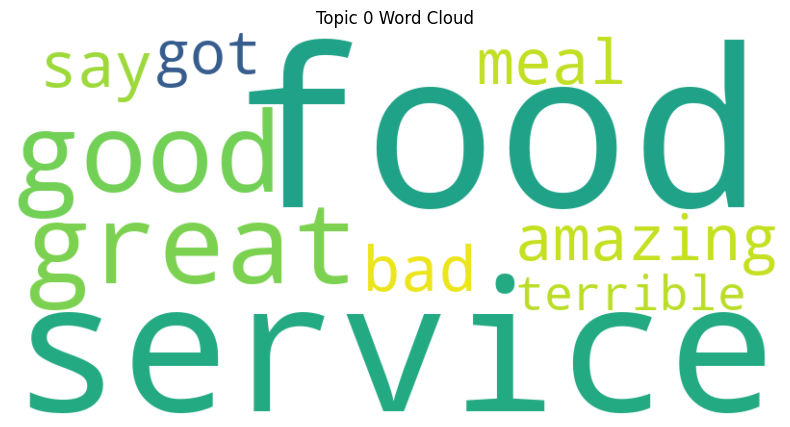

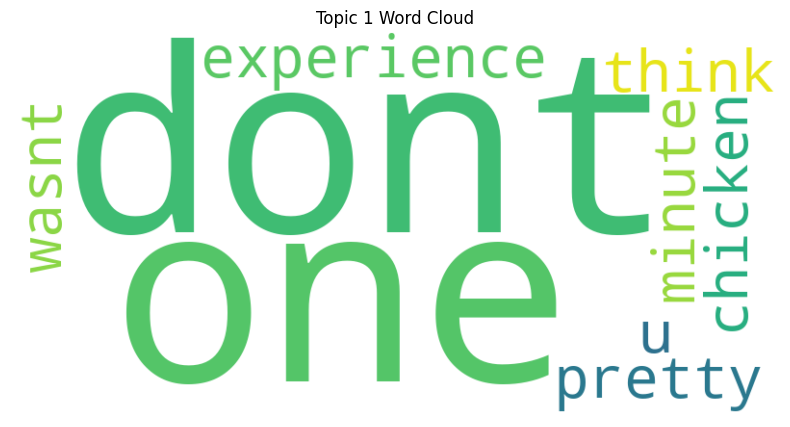

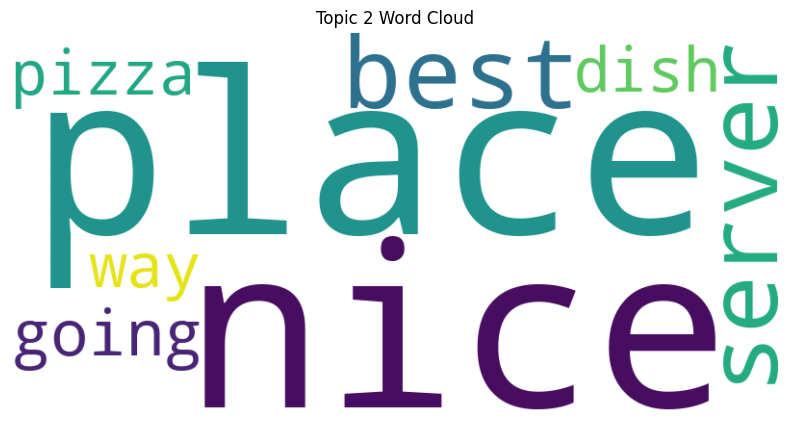

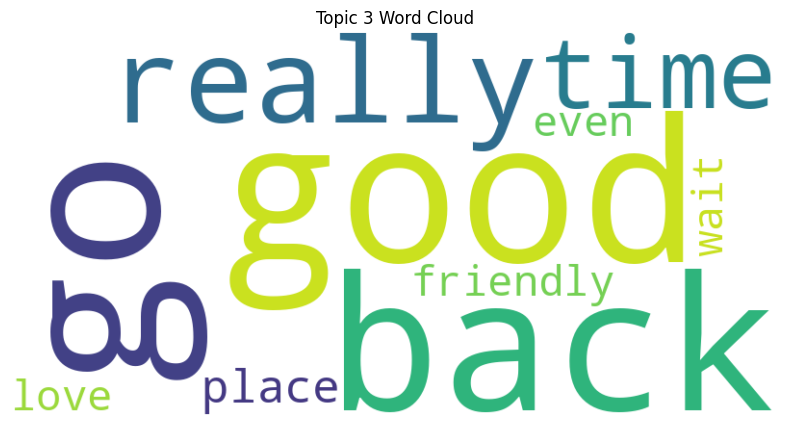

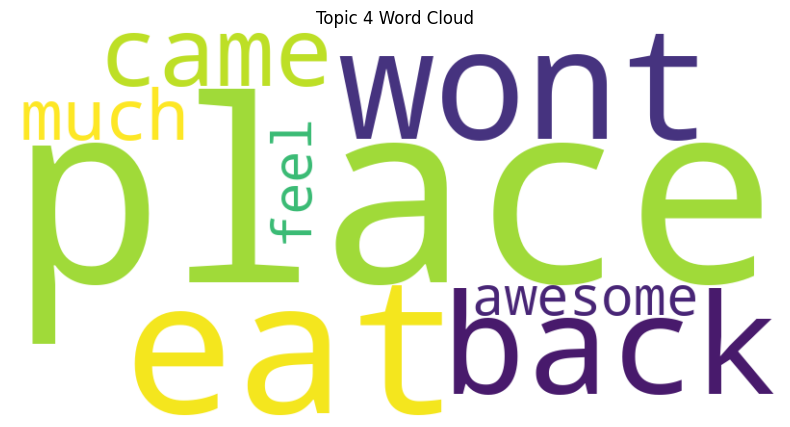

In [20]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Prepare keywords for WordCloud for each topic
topic_words = []
for i in range(lda_model.num_topics):
    words = lda_model.show_topic(i, topn=10)
    topic_words.append(" ".join([word for word, prob in words]))

# Generate and display word clouds for each topic
for i, words_str in enumerate(topic_words):
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(words_str)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(f'Topic {i} Word Cloud')
    plt.axis('off')
    plt.show()

**Reasoning**:
To summarize the sentiment by topic, I will group the DataFrame by 'dominant_topic' and 'Sentiment', calculate the count for each sentiment within each topic, and then normalize these counts to get percentages. This will provide a clear overview of the sentiment distribution for each identified topic.



In [21]:
sentiment_by_topic = df.groupby(['dominant_topic', 'Sentiment']).size().unstack(fill_value=0)
sentiment_by_topic_percentage = sentiment_by_topic.apply(lambda x: x / x.sum() * 100, axis=1)

print("Sentiment Distribution by Topic (Percentages):")
print(sentiment_by_topic_percentage)


Sentiment Distribution by Topic (Percentages):
Sentiment        Negative    Neutral   Positive
dominant_topic                                 
0               30.882353  18.014706  51.102941
1               28.651685  33.707865  37.640449
2               21.556886  16.766467  61.676647
3               17.961165  27.184466  54.854369
4               26.553672  25.988701  47.457627


### ✍️ Your Response: 🔧
List your topics and names here:
Topic 0 - Food & Service Quality (Keywords: food, service, great, good, amazing, meal, bad, terrible)
Topic 1 - Negative Experience (Keywords: dont, one, also, experience, u, pretty, chicken, think, wasnt, minute)
Topic 2 - Best Place/Server (Keywords: place, ever, nice, best, would, server, going, pizza, dish, way)
Topic 3 - Good Times/Return (Keywords: good, go, back, really, time, place, friendly, even, love, wait)
Topic 4 - General Dining Experience (Keywords: like, place, eat, get, wont, back, came, much, awesome, feel)

## 8. Reflect and Recommend

**Business framing:**  
Ultimately, the value of your model comes from how well it can guide business decisions. Use your results to make real-world recommendations.

### In Your Response:
1. What business question did your model help answer?
2. What would you recommend to this restaurant to improve customer satisfaction?
3. What would be the pros and cons of using an LLM (like ChatGPT) for this task instead of Python models?
4. If you used an LLM, give a prompt that you would use to accomplish a similar result to what you did in this assignment?  (remember to set the context, specify the output and explain the objectives)


### ✍️ Your Response: 🔧
1. Our model helped answer the overarching business question: "What are the main themes (topics) customers are discussing in their reviews, what is the sentiment associated with these themes, and how does this feedback align with their overall satisfaction (Liked/Not Liked)?" More specifically, it helped to answer:

What are the predominant positive and negative aspects mentioned in customer reviews?
Are there specific areas (e.g., food, service, atmosphere) that consistently receive positive or negative feedback?
How do specific topics contribute to overall customer satisfaction or dissatisfaction?

2. Based on the topic and sentiment analysis, here are some recommendations:

Prioritize addressing 'Negative Experience' (Topic 1): This topic shows the highest percentage of negative sentiment (28.65%) and a significant neutral component (33.71%). Deep dive into these reviews to pinpoint specific issues related to 'experience', 'don't like', 'wasn't', 'minute' (possibly waiting times), and 'chicken' (a specific dish). This is the most direct path to reducing dissatisfaction.
Maintain and Leverage Strengths in 'Food & Service Quality' (Topic 0) and 'Best Place/Server' (Topic 2): These topics show strong positive sentiment (51.10% and 61.68% respectively). Continue to focus on delivering high-quality food and excellent service. Highlight these strengths in marketing and staff training. Encourage reviews that mention these aspects.
Convert 'Neutral' Experiences (Topic 3 & 4): Topics like 'Good Times/Return' (Topic 3) and 'General Dining Experience' (Topic 4) have a notable percentage of neutral sentiment (27.18% and 25.99%). This indicates customers are neither thrilled nor disappointed. The restaurant should explore ways to elevate these 'okay' experiences into 'great' ones. For Topic 3, 'friendly' and 'love' are present, suggesting that reinforcing staff friendliness and creating a more memorable atmosphere could turn neutral experiences into positive ones, encouraging customers to 'go back'. For Topic 4, focusing on making the 'place' and overall 'feel' more 'awesome' could be beneficial.
Monitor Specific Keywords: Regularly track mentions of 'chicken' (Topic 1), 'pizza' (Topic 2), and 'wait' (Topic 3). These specific items or issues are common enough to appear in topics and warrant continuous monitoring.

3. Pros of using an LLM:

Ease of Use & Accessibility: LLMs require no coding expertise. Users can simply type natural language prompts.
Rapid Prototyping: Quick generation of insights for initial exploration or small datasets.
Contextual Understanding & Nuance: LLMs can understand subtle nuances, sarcasm, and context within reviews better than rule-based or traditional statistical models, potentially leading to more insightful topic interpretations without manual keyword analysis.
Zero-Shot Learning: Can perform tasks without explicit training data, making it adaptable to new datasets instantly.
Human-like Summaries: Can directly provide human-readable summaries and actionable insights in plain language, reducing the need for manual interpretation of model outputs.
Cons of using an LLM:

Lack of Control & Reproducibility: The output of LLMs can be less predictable and harder to reproduce or fine-tune systematically compared to explicit Python code.
Cost & Privacy: API usage often incurs costs, and sending sensitive customer data to external LLM services can raise privacy concerns.
Hallucinations & Bias: LLMs can sometimes generate incorrect, misleading, or biased information, requiring careful human oversight.
Scalability for Large Datasets: Processing very large datasets through LLM APIs can be slow and expensive.
Lack of Granular Metrics: It's harder to get precise metrics like topic coherence scores, per-document topic distributions, or statistical significance that traditional models provide.
Dependence on Prompt Engineering: The quality of results heavily depends on the clarity and specificity of the prompt.

4. LLM Prompt: "You are an expert in restaurant business analytics. I will provide you with a dataset of 1000 customer reviews for a restaurant, along with a binary 'Liked' indicator (1 for liked, 0 for not liked) and sentiment scores (Positive, Neutral, Negative) for each review. Your task is to perform a comprehensive text analysis to extract actionable insights for the restaurant owner.

Context: The restaurant wants to understand what customers are saying, identify key areas of satisfaction and dissatisfaction, and pinpoint specific improvement opportunities.

Objectives:

Topic Extraction: Identify the main recurring themes or topics within the customer reviews.
Sentiment Analysis by Topic: Determine the sentiment distribution (positive, neutral, negative percentages) for each identified topic.
Business Recommendations: Provide concrete, actionable recommendations to improve customer satisfaction and address pain points, based on your analysis.
Output Requirements:

Overall Liked vs. Not Liked Percentage: Report the percentage of 'Liked' vs. 'Not Liked' reviews.
Overall Sentiment Distribution: Report the overall percentage of Positive, Neutral, and Negative reviews.
Identified Topics: For each main topic, list 5-7 key words that define it and propose a concise 2-3 word name for the topic.
Topic Frequency: State how prevalent each topic is in the reviews (e.g., as a percentage of reviews that discuss it).
Sentiment Breakdown per Topic: For each topic, provide the percentage of positive, neutral, and negative reviews it contains.
Top 3 Actionable Recommendations: Based on the entire analysis, provide the top three specific, actionable recommendations for the restaurant to improve customer satisfaction. Justify each recommendation with data from your analysis.

## Submission Instructions
✅ Checklist:
- All code cells run without error
- All markdown responses are complete
- Submit on Canvas as instructed

In [22]:
!jupyter nbconvert --to html "assignment_13_ChristensenBryson.ipynb"

[NbConvertApp] Converting notebook assignment_13_ChristensenBryson.ipynb to html
[NbConvertApp] ERROR | Notebook JSON is invalid: Additional properties are not allowed ('errorDetails' was unexpected)

Failed validating 'additionalProperties' in error:

On instance['cells'][38]['outputs'][0]:
{'ename': 'ModuleNotFoundError',
 'errorDetails': {'actions': [{'action': 'open_url',
                               'actionText': 'Open Examples',
                               'url': '/notebooks/snippets/importing_libraries.ipynb'}]},
 'evalue': "No module named 'gensim'",
 'output_type': 'error',
 'traceback': ['\x1b---------------------------------------------------------...',
               '\x1bModuleNotFoundError\x1b                       '
               'Traceback (...',
               '\x1b/tmp/ipython-input-1356781121.py\x1b in '
               '\x1b<cell line...',
               '\x1bModuleNotFoundError\x1b: No module named '
               "'gensim'",
               '',
              